In [1]:
#Dataset Paths
train_initial_data = './Datasets/train_data_converted_json_to_csv1_0.csv'
train_data_sampled = './Datasets/train_data_sampled.csv'

In [2]:
!pip install transformers

In [3]:
!pip install -U scikit-learn scipy matplotlib
!pip install pandas
!pip install seaborn
!pip install nltk

In [4]:
import numpy as np
import pandas as pd
import torch
from transformers import BertTokenizer,BertModel,AdamW, get_linear_schedule_with_warmup
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,Dataset
from torch.nn.utils.rnn import pack_padded_sequence
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm
from argparse import ArgumentParser
import warnings  
warnings.filterwarnings('ignore')

# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [5]:
device = torch.device("cuda:5" if torch.cuda.is_available() else "cpu")

In [6]:
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)


In [7]:
# from google.colab import drive
# drive.mount('/content/drive')

In [8]:
import pandas as pd

df = pd.read_csv(train_initial_data)

In [9]:
print(len(df))

28986


In [10]:
df.head()

,start,end,text,labels
0,0,116,"IN THE HIGH COURT OF KARNATAKA,\n ...",['PREAMBLE']
1,116,678,\n\n BEFORE\n\nTHE HON'BLE MR.JUSTICE ANA...,['PREAMBLE']
2,678,964,This Criminal Appeal is filed under Section 37...,['PREAMBLE']
3,964,1093,\n\n This appeal coming on for hearing t...,['PREAMBLE']
4,1093,1180,\n Heard the learned Counsel for the app...,['NONE']


In [11]:
data_df = df
print(data_df.head())

   start   end                                               text  \
0      0   116        IN THE HIGH COURT OF KARNATAKA,\n       ...   
1    116   678  \n\n      BEFORE\n\nTHE HON'BLE MR.JUSTICE ANA...   
2    678   964  This Criminal Appeal is filed under Section 37...   
3    964  1093  \n\n       This appeal coming on for hearing t...   
4   1093  1180  \n       Heard the learned Counsel for the app...   

         labels  
0  ['PREAMBLE']  
1  ['PREAMBLE']  
2  ['PREAMBLE']  
3  ['PREAMBLE']  
4      ['NONE']  


In [12]:
df['text'][0]

'      IN THE HIGH COURT OF KARNATAKA,\n          CIRCUIT BENCH AT GULBARGA\n\nDATED THIS THE 22ND DAY OF FEBRUARY, 2013'

In [13]:
print(len(df))

28986


In [14]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /soe/parikshithh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /soe/parikshithh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [15]:
#Data preprocessing function
import re
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
def preprocess(data_df):
  data_df['text'] = data_df['text'].apply(lambda t: t.lower()) #Convert to lower
  data_df['text'] = data_df['text'].apply(lambda t: re.sub("\n", ' ', t)) #Remove new line 
  data_df['text'] = data_df['text'].apply(lambda t: re.sub(r'\.{2,}','.', t)) #regular expression for normalizing repeated ... patterns
  data_df['text'] = data_df['text'].apply(lambda t: re.sub(r'[\"\"#\$%&\(\)\*\+,-/:;<=>\@\[\\\]\^_`{\|}~]', ' ', t)) #remove punctuations
  data_df['text'] = data_df['text'].apply(lambda t: re.sub('"', '', t)) #remove redundant ""
  data_df['text'] = data_df['text'].str.replace('\d+', '') #remove numbers
  data_df['text'] = data_df['text'].str.strip() #remove extra spaces
  data_df['text'] = data_df['text'].apply(lambda t: ' '.join(t.strip().split()))
  data_df['labels'] = data_df['labels'].str.replace(r'[\[\]\'\']', '') #remove punctuations from labels
  data_df['text'] = data_df['text'].str.replace(' +$', '')  #remove extra spaces at end
  data_df['labels'] = data_df['labels'].apply(lambda t: t.lower()) #convert to lower of labels
  data_df['text'] = data_df['text'].apply(lambda t: ' '.join([t for t in nltk.word_tokenize(t) if t.lower() not in stop_words])) #removal of stop words and tokenization
  return data_df

In [16]:
new_data_df_1= preprocess(data_df)

In [17]:
new_data_df_1.head()

,start,end,text,labels
0,0,116,high court karnataka circuit bench gulbarga da...,preamble
1,116,678,hon'ble mr justice anand byrareddy criminal ap...,preamble
2,678,964,criminal appeal filed section code criminal pr...,preamble
3,964,1093,appeal coming hearing day court delivered foll...,preamble
4,1093,1180,heard learned counsel appellant learned govern...,none


In [18]:
new_data_df_1['text'][0]

'high court karnataka circuit bench gulbarga dated nd day february'

In [19]:
print(new_data_df_1['labels'][0])

preamble


In [20]:
print(len(new_data_df_1))

28986


In [21]:
#Getting number of samples for data sampling
count =0
count_1 =0
count_2=0
for i in range(0,len(new_data_df_1)):
  if new_data_df_1['labels'][i] == 'analysis':
    count=count+1
  elif new_data_df_1['labels'][i] == 'preamble':
    count_1=count_1+1
  elif new_data_df_1['labels'][i] == 'fac':
    count_2=count_2+1
print(count)
print(count_1)
print(count_2)

10695
4167
5744


In [22]:
df_1 = new_data_df_1[new_data_df_1['labels'] != 'analysis']

In [23]:
df2 = df_1[df_1['labels'] != 'preamble']

In [24]:
df3 = df2[df2['labels'] != 'fac']

In [25]:
new_df1 = new_data_df_1[new_data_df_1.labels == 'analysis'].sample(1600)
new_df2 = new_data_df_1[new_data_df_1.labels == 'preamble'].sample(1600)
new_df3 = new_data_df_1[new_data_df_1.labels == 'fac'].sample(1600)

In [26]:
frames = [new_df1, new_df2, new_df3, df3]

In [27]:
res = pd.concat(frames)

In [28]:
res

,start,end,text,labels
9978,12852,13011,none major points decided appellate commission...,analysis
17646,33396,33443,could get pulse heart beats usha,analysis
821,22086,22207,must addition assembly assembly must common ob...,analysis
8591,10794,11104,counsel submits person liable pay tax may foun...,analysis
4673,20732,20951,ms kusum dhalla learned app referred evidence ...,analysis
...,...,...,...,...
28981,21494,21601,section evidence act sufficiently protects sin...,ratio
28982,21601,21652,reasons aforesaid appeal allowed,rpc
28983,21653,21761,judgment order dated april passed revision pet...,rpc
28984,21761,21769,r,none


In [29]:
res.to_csv(train_data_sampled)

{'analysis': 1600, 'preamble': 1600, 'fac': 1600, 'pre_relied': 1431, 'none': 1423, 'arg_petitioner': 1315, 'rpc': 1081, 'rlc': 752, 'arg_respondent': 698, 'ratio': 674, 'sta': 481, 'issue': 367, 'pre_not_relied': 158}


<AxesSubplot: title={'center': 'Number of Occurrence of each tags'}>

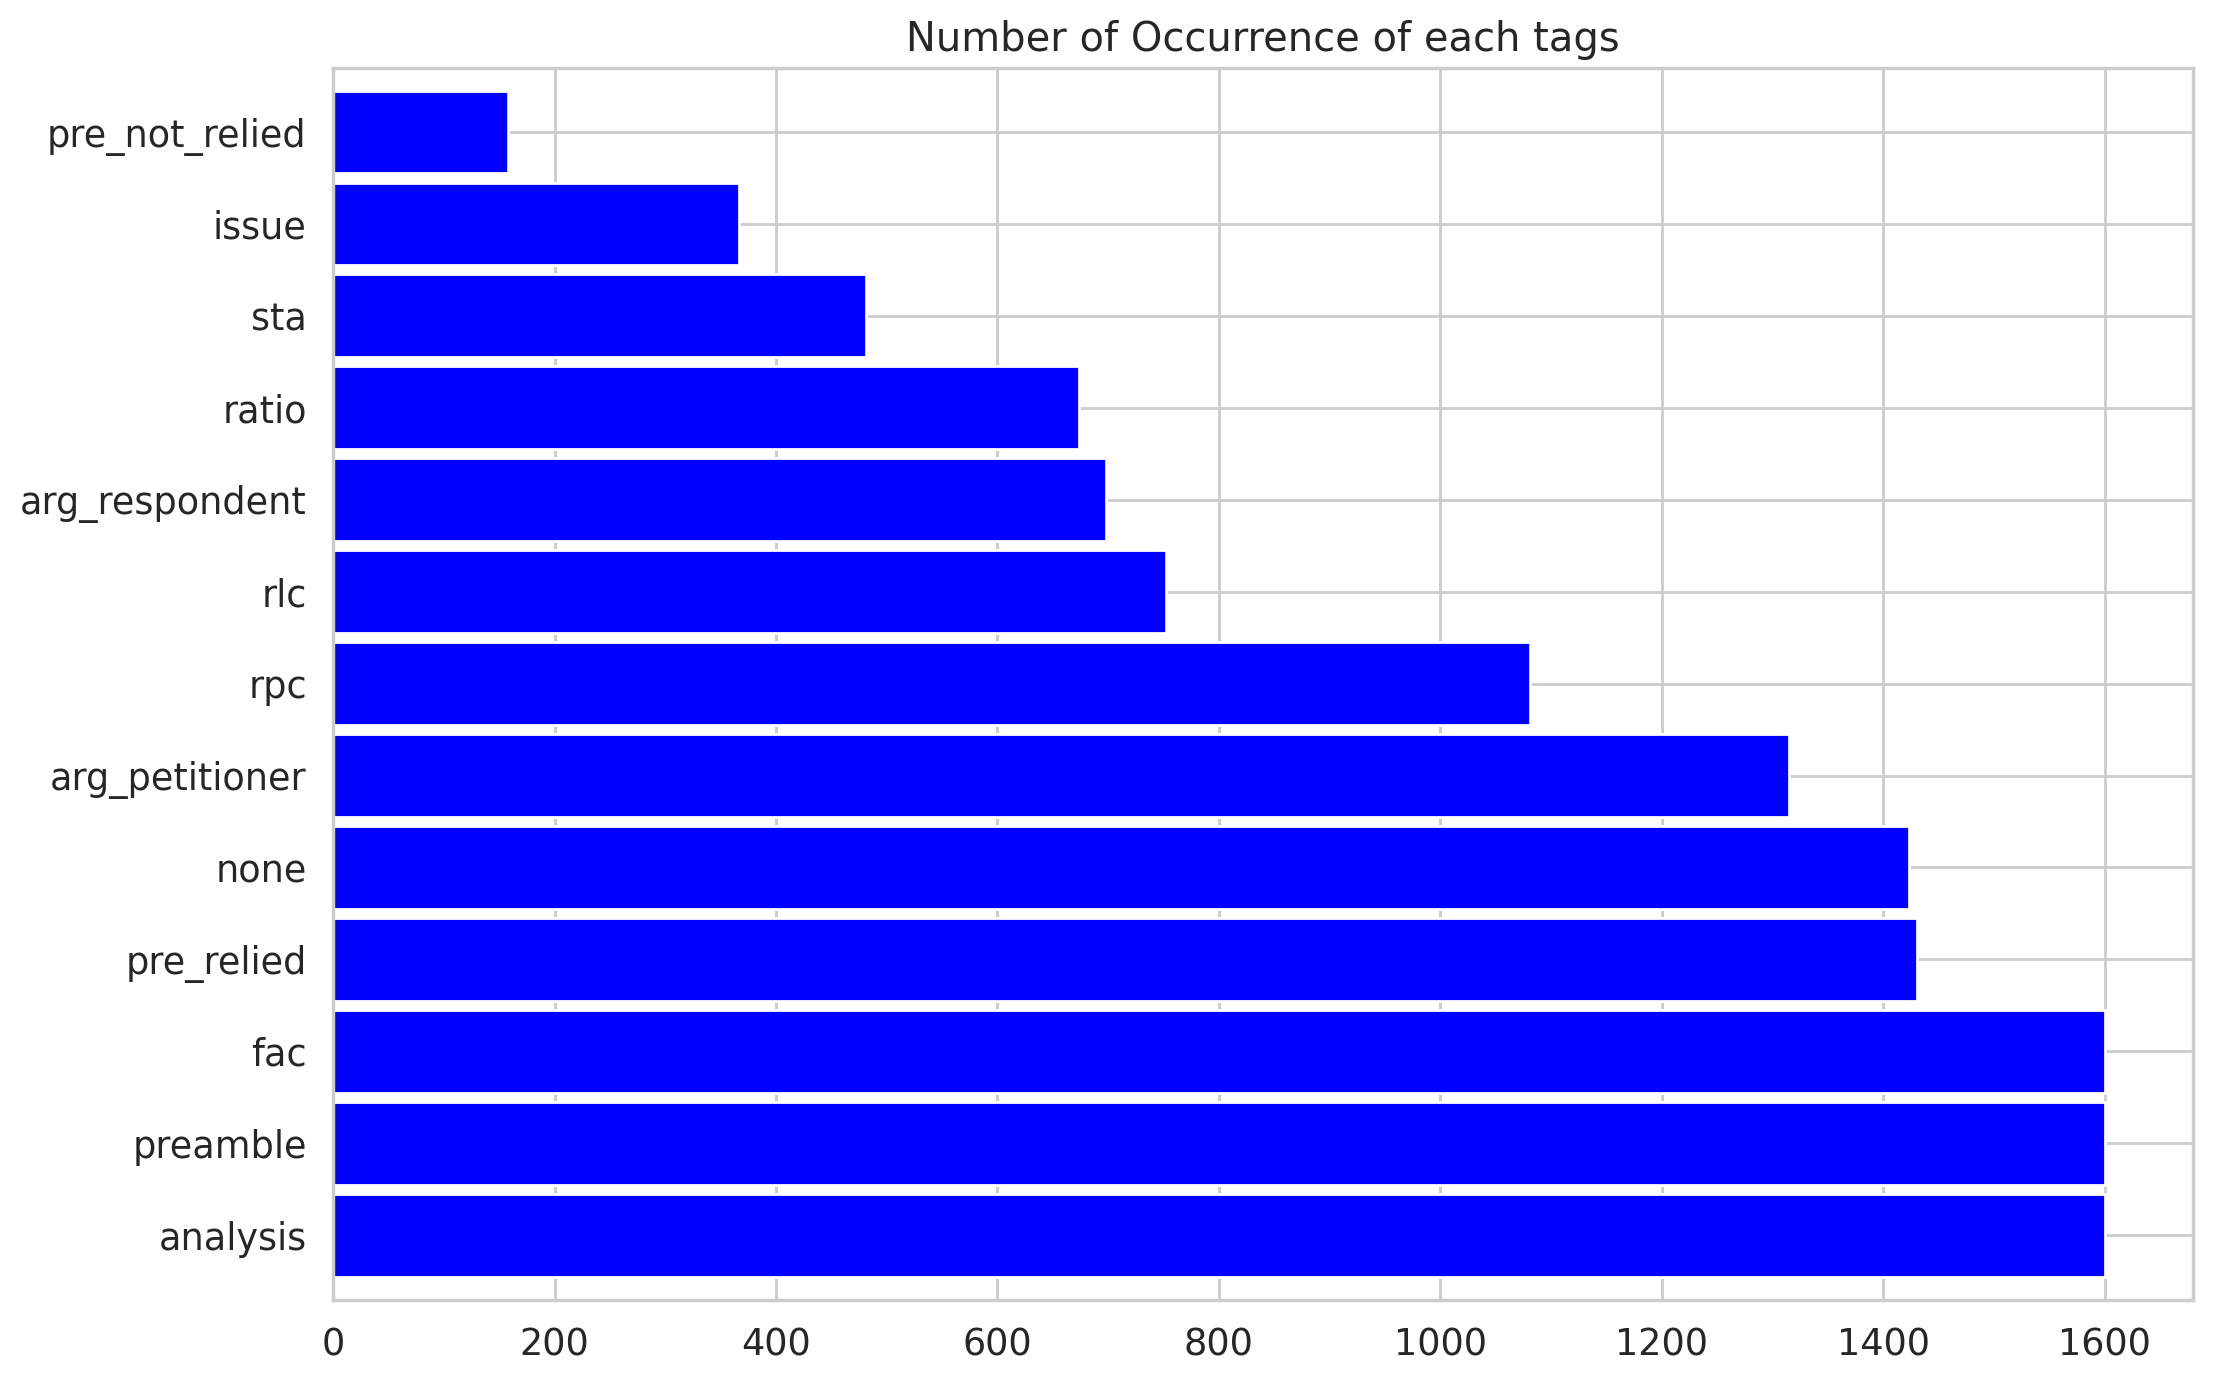

In [30]:
labels_print = res['labels']
labels_print_count = labels_print.explode().value_counts()
print(dict(labels_print_count))
labels_print_count.plot(kind="barh", width=0.9, color="blue", title="Number of Occurrence of each tags")

In [31]:
new_data_df = pd.read_csv(train_data_sampled)

In [32]:
new_data_df

,Unnamed: 0,start,end,text,labels
0,9978,12852,13011,none major points decided appellate commission...,analysis
1,17646,33396,33443,could get pulse heart beats usha,analysis
2,821,22086,22207,must addition assembly assembly must common ob...,analysis
3,8591,10794,11104,counsel submits person liable pay tax may foun...,analysis
4,4673,20732,20951,ms kusum dhalla learned app referred evidence ...,analysis
...,...,...,...,...,...
13175,28981,21494,21601,section evidence act sufficiently protects sin...,ratio
13176,28982,21601,21652,reasons aforesaid appeal allowed,rpc
13177,28983,21653,21761,judgment order dated april passed revision pet...,rpc
13178,28984,21761,21769,r,none


In [33]:
# testing of tokenizer

tokens = tokenizer.tokenize(new_data_df['text'][0])
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(tokenizer)
print(token_ids)

print(tokenizer.sep_token, tokenizer.sep_token_id)
print(tokenizer.cls_token, tokenizer.cls_token_id)
print(tokenizer.pad_token, tokenizer.pad_token_id)
print(tokenizer.unk_token, tokenizer.unk_token_id)

PreTrainedTokenizer(name_or_path='bert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})
[3904, 2350, 2685, 2787, 23240, 5849, 4660, 12152, 4292, 4998, 2344, 2979, 23240, 5849]
[SEP] 102
[CLS] 101
[PAD] 0
[UNK] 100


In [34]:
#Getting tokens count
token_lens = []
for txt in new_data_df.text:
  tokens = tokenizer.encode(str(txt), max_length=512, truncation=True)
  token_lens.append(len(tokens))

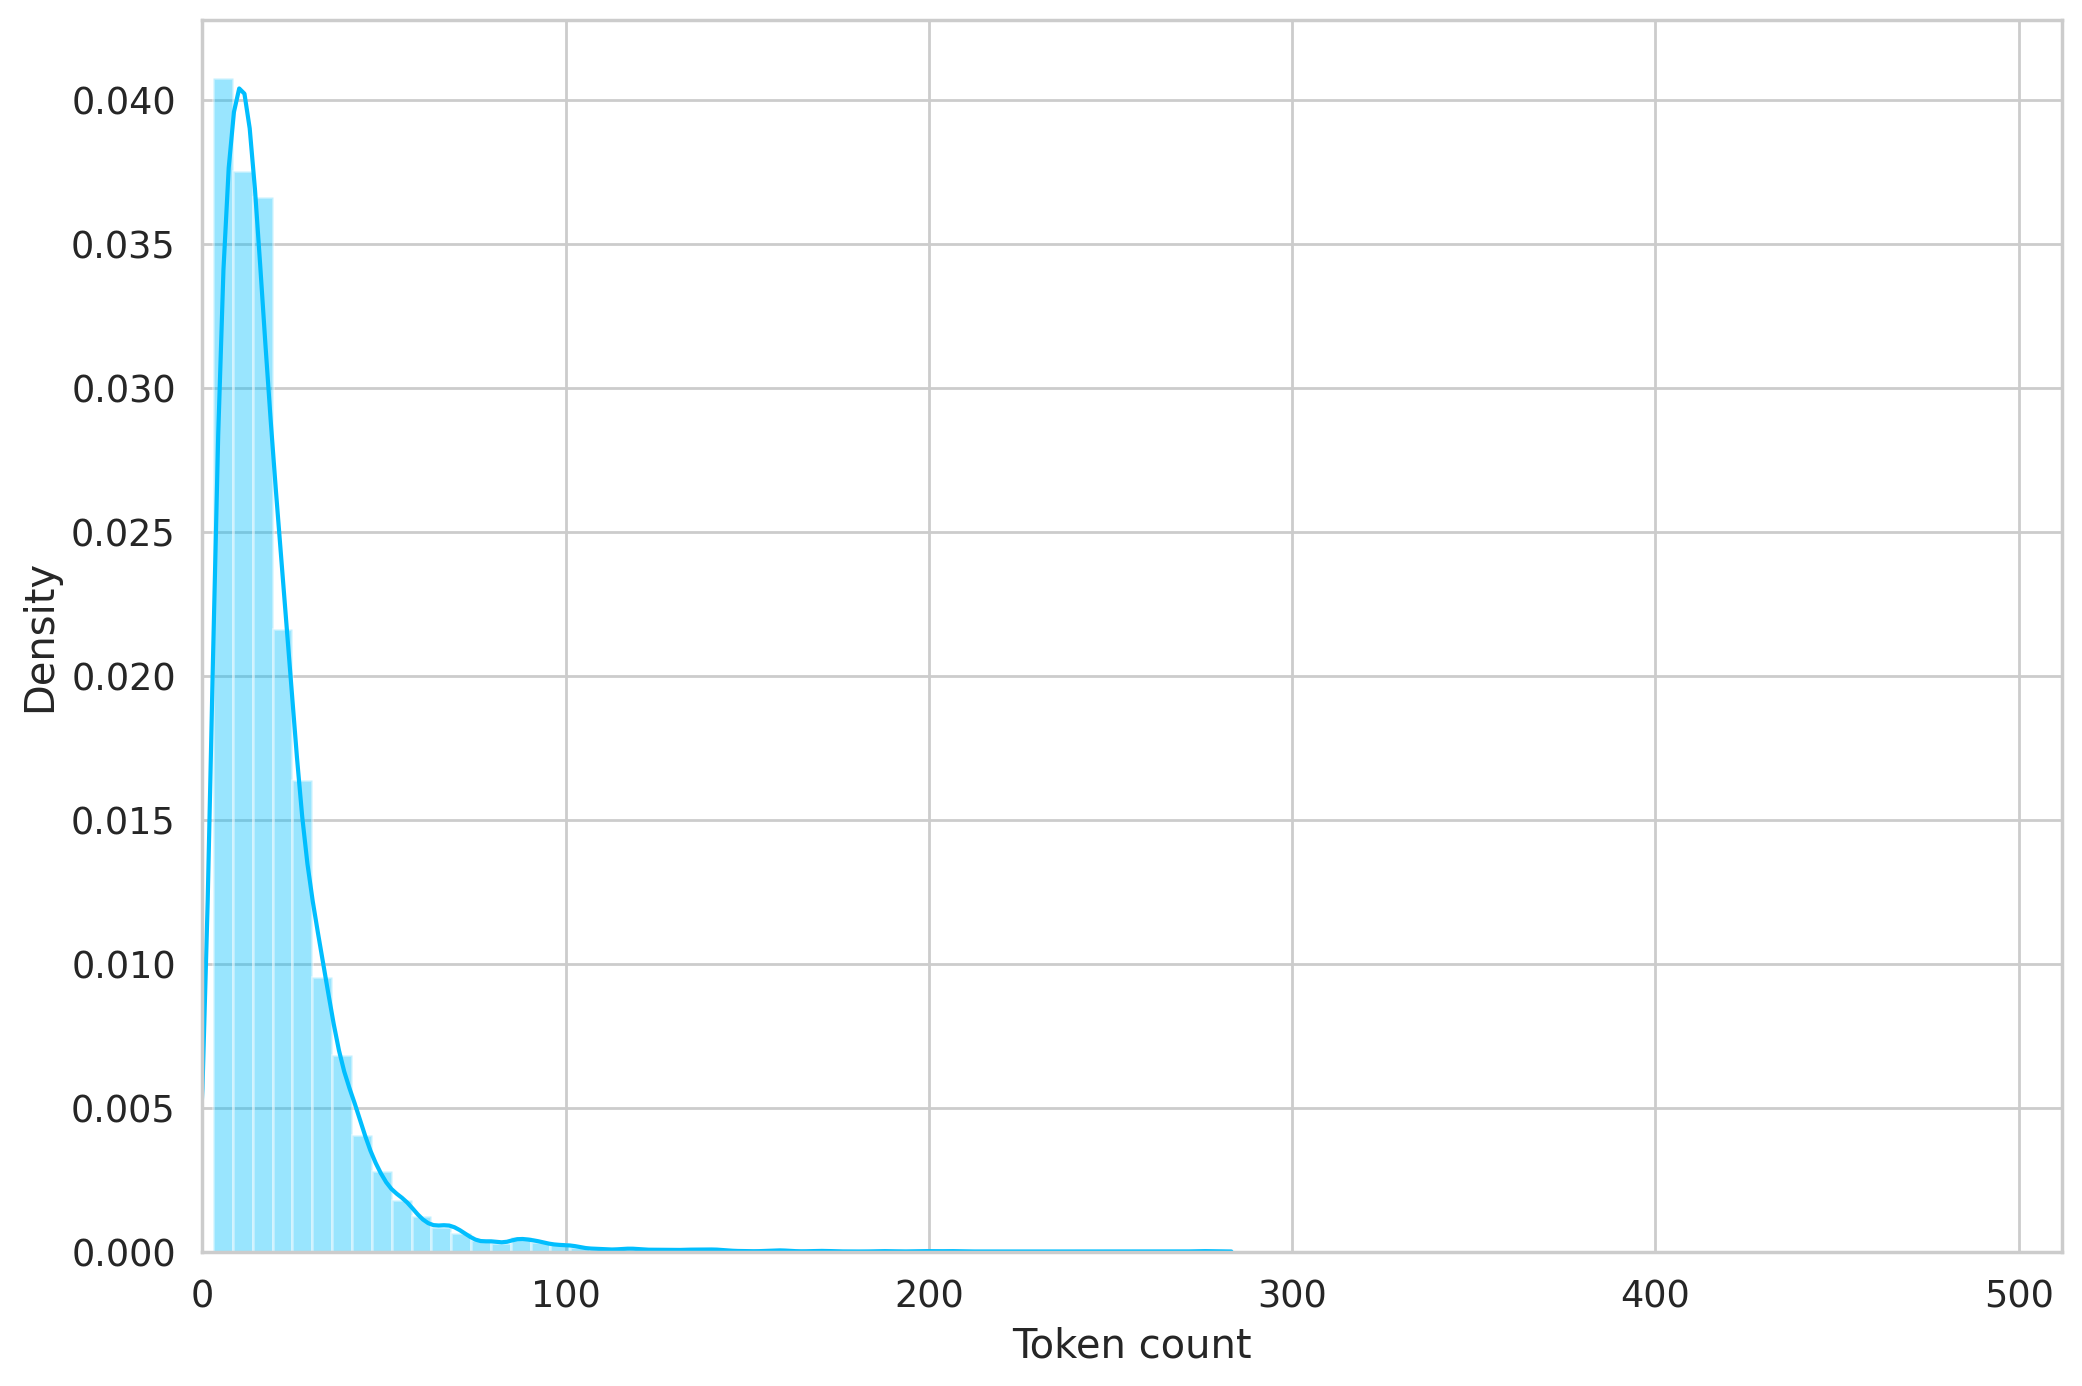

In [35]:
#Getting maximum tokens count plot
sns.distplot(token_lens)
plt.xlim([0, 512]);
plt.xlabel('Token count');

In [36]:
max_l = max(token_lens)
print(max_l)

276


#classes


In [37]:
# getting labels list
labels_list=[]

for i in new_data_df.labels:
  labels_list.append(i)

labels_set = set(labels_list)
print(labels_set)


{'pre_not_relied', 'none', 'preamble', 'fac', 'rlc', 'rpc', 'issue', 'sta', 'pre_relied', 'arg_respondent', 'ratio', 'arg_petitioner', 'analysis'}


In [38]:
# index to labels
itol ={}
ltoi ={}
ind =0
for i in labels_set:
  itol[ind]=i
  ltoi[i]= ind
  ind =ind+1


In [39]:
for i in range(0,len(new_data_df)):
  new_data_df.loc[i,["labels"]]=ltoi[new_data_df["labels"][i]]

In [40]:
#Dataset class to load the data and convert into tensor
class Legaleval(Dataset): 
  def __init__(self, text, targets, tokenizer, max_len):
    self.content = text #sentence converted to indices list
    self.targets = targets # lables 
    self.tokenizer = tokenizer # BERT tokenizer
    self.max_len = max_len # maximum tokem count found among all the sentences in the datasets

  def __len__(self):
    return len(self.content) # here content represents the text  

  def __getitem__(self, item): #getting an encoded item
    text = str(self.content[item])# getting the sentence 
    target = self.targets[item] # label 
    # encoding the sentence using inbulit encode_plus from Bert
    encoding = self.tokenizer.encode_plus(text,add_special_tokens=True,max_length=self.max_len,return_token_type_ids=False,pad_to_max_length=True,return_attention_mask=True,return_tensors='pt',truncation=True)
    return {
      'Legal_text': text, # text used to find encoding
      'input_ids': encoding['input_ids'].flatten(),# encoded the indices of the tokens from the given sentence
      'attention_mask': encoding['attention_mask'].flatten(),# attention layer
      'targets': torch.tensor(target, dtype=torch.long)# converting the lables lists to tensor
    }

In [41]:
#Spliting of Dataset
from sklearn.model_selection import train_test_split # splitting the data 

df_train, df_test = train_test_split(new_data_df,test_size=0.1,random_state=RANDOM_SEED)# first the given data is split int train and test data.
df_val, df_test = train_test_split(df_test,test_size=0.5,random_state=RANDOM_SEED)# then the test data is split into validation and test data .

In [42]:
# data loder creation
def data_loader(df, tokenizer, max_len, batch_size): 
  final_data = Legaleval(text=df.text.to_numpy(),targets=df.labels.to_numpy(),tokenizer=tokenizer,max_len=max_len)
  return DataLoader(final_data,batch_size=batch_size,num_workers=4)

BATCH_SIZE = 16 #batch size
MAX_LENGTH = max_l #maximum token count

train_data_loader = data_loader(df_train, tokenizer, MAX_LENGTH, BATCH_SIZE) #creating train data loader
val_data_loader = data_loader(df_val, tokenizer, MAX_LENGTH, BATCH_SIZE) #creating validation data loader
test_data_loader = data_loader(df_test, tokenizer, MAX_LENGTH, BATCH_SIZE) #creating test data loader
 

In [43]:
#BERT Model Class
class BERT(nn.Module):
  def __init__(self,em_dim,output_tokens,padding_index=0):
        super(BERT,self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased',return_dict=False) # Bert is used as embedding
        self.drop = nn.Dropout(0.3) 
        self.fc1 = nn.Linear(self.bert.config.hidden_size, output_tokens)# fully onnected linear layer
        
  def forward(self,input_ids, attention_mask):
        _, pooled_output = self.bert(input_ids=input_ids,attention_mask=attention_mask)
        x=self.drop(pooled_output)
        h2 = self.fc1(x)
        return h2

In [44]:
model_bert = BERT(300,len(labels_set)) # intializing the model
model_bert = model_bert.to(device) 

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [45]:
# hyperparameters 
EPOCHS = 7
total_steps = len(train_data_loader) * EPOCHS
optimizer = AdamW(model_bert.parameters(), lr=2e-5, correct_bias=False)
loss_fn = nn.CrossEntropyLoss().to(device)
scheduler = get_linear_schedule_with_warmup(optimizer,num_warmup_steps=0,num_training_steps=total_steps)

In [46]:
# training the data
def training(model,data_loader,loss_fn,optimizer,device,scheduler,n_examples):
  model = model.train()# set the model for training
  losses = [] # storing the values of losses found
  correct_predictions = 0
  pbar = tqdm(data_loader)
  for element in pbar: 
    input_ids = element["input_ids"].to(device) #getting encoded tensor of sequence
    attention_mask = element["attention_mask"].to(device) #getting mask sequence
    targets = element["targets"].to(device) #getting labels
    outputs = model(input_ids=input_ids,attention_mask=attention_mask) 
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets) # finding loss
    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
  return correct_predictions.double() / n_examples, np.mean(losses) #returns training accuracy and loss

In [47]:
def evaluation(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    pbar = tqdm(data_loader)
    for element in pbar:
      input_ids = element["input_ids"].to(device) #getting encoded tensor of sequence
      attention_mask = element["attention_mask"].to(device) #getting mask sequence
      targets = element["targets"].to(device) #getting labels
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, targets)
      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())
  return correct_predictions.double() / n_examples, np.mean(losses) #returns evaluation accuracy and loss

In [48]:
#Code to run the training and evaluation
from collections import defaultdict
history = defaultdict(list)

training_acc = [] #list to store training accuracies
training_loss =[] # list to store training loss
validation_acc = [] # list to store validation accuracys
validation_loss =[] # list to store validation losses

best_accuracy = 0
for epoch in range(EPOCHS):
  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)
  train_acc, train_loss = training(model_bert,train_data_loader,loss_fn,optimizer,device,scheduler,len(df_train))
  print(f'Train loss {train_loss} accuracy {train_acc}')
  val_acc, val_loss = evaluation(model_bert,val_data_loader,loss_fn,device,len(df_val))
  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()
  history['train_acc'].append(train_acc)
  training_acc.append(train_acc)
  history['train_loss'].append(train_loss)
  training_loss.append(train_loss)
  history['val_acc'].append(val_acc)
  validation_acc.append(val_acc)
  history['val_loss'].append(val_loss)
  validation_loss.append(val_loss)
  if val_acc > best_accuracy:
    torch.save(model_bert.state_dict(), 'best_model_state_bert.bin') #saving the best model
    best_accuracy = val_acc

Epoch 1/7
----------


100%|█████████████████████████████████████████| 742/742 [02:45<00:00,  4.50it/s]


Train loss 1.757472136592608 accuracy 0.42134547293879615


100%|███████████████████████████████████████████| 42/42 [00:03<00:00, 13.99it/s]


Val   loss 1.5011043804032462 accuracy 0.5083459787556904

Epoch 2/7
----------


100%|█████████████████████████████████████████| 742/742 [02:46<00:00,  4.45it/s]


Train loss 1.2331147537318201 accuracy 0.5971168437025797


100%|███████████████████████████████████████████| 42/42 [00:02<00:00, 14.32it/s]


Val   loss 1.4552953172297705 accuracy 0.5204855842185129

Epoch 3/7
----------


100%|█████████████████████████████████████████| 742/742 [02:42<00:00,  4.57it/s]


Train loss 0.9376459955928139 accuracy 0.7008936098465689


100%|███████████████████████████████████████████| 42/42 [00:03<00:00, 13.76it/s]


Val   loss 1.5254003150122506 accuracy 0.5280728376327769

Epoch 4/7
----------


100%|█████████████████████████████████████████| 742/742 [02:41<00:00,  4.60it/s]


Train loss 0.7111123480967113 accuracy 0.7787894115663463


100%|███████████████████████████████████████████| 42/42 [00:03<00:00, 13.97it/s]


Val   loss 1.583041699159713 accuracy 0.5311077389984825

Epoch 5/7
----------


100%|█████████████████████████████████████████| 742/742 [02:43<00:00,  4.54it/s]


Train loss 0.5505636488049821 accuracy 0.8342606643061878


100%|███████████████████████████████████████████| 42/42 [00:02<00:00, 14.15it/s]


Val   loss 1.6779171945083708 accuracy 0.5311077389984825

Epoch 6/7
----------


100%|█████████████████████████████████████████| 742/742 [02:42<00:00,  4.57it/s]


Train loss 0.4403366250365049 accuracy 0.866464339908953


100%|███████████████████████████████████████████| 42/42 [00:02<00:00, 14.32it/s]


Val   loss 1.7529804373071307 accuracy 0.5341426403641882

Epoch 7/7
----------


100%|█████████████████████████████████████████| 742/742 [02:42<00:00,  4.56it/s]


Train loss 0.37512025085712136 accuracy 0.887287135390322


100%|███████████████████████████████████████████| 42/42 [00:02<00:00, 14.13it/s]

Val   loss 1.8190778962203435 accuracy 0.5295902883156297



In [49]:
new_training_acc =[]
for i in training_acc:
  x= i.to("cpu") 
  final = x.numpy()
  new_training_acc.append(final)

new_validation_acc =[]
for i in validation_acc:
  x= i.to("cpu") 
  final = x.numpy()
  new_validation_acc.append(final)

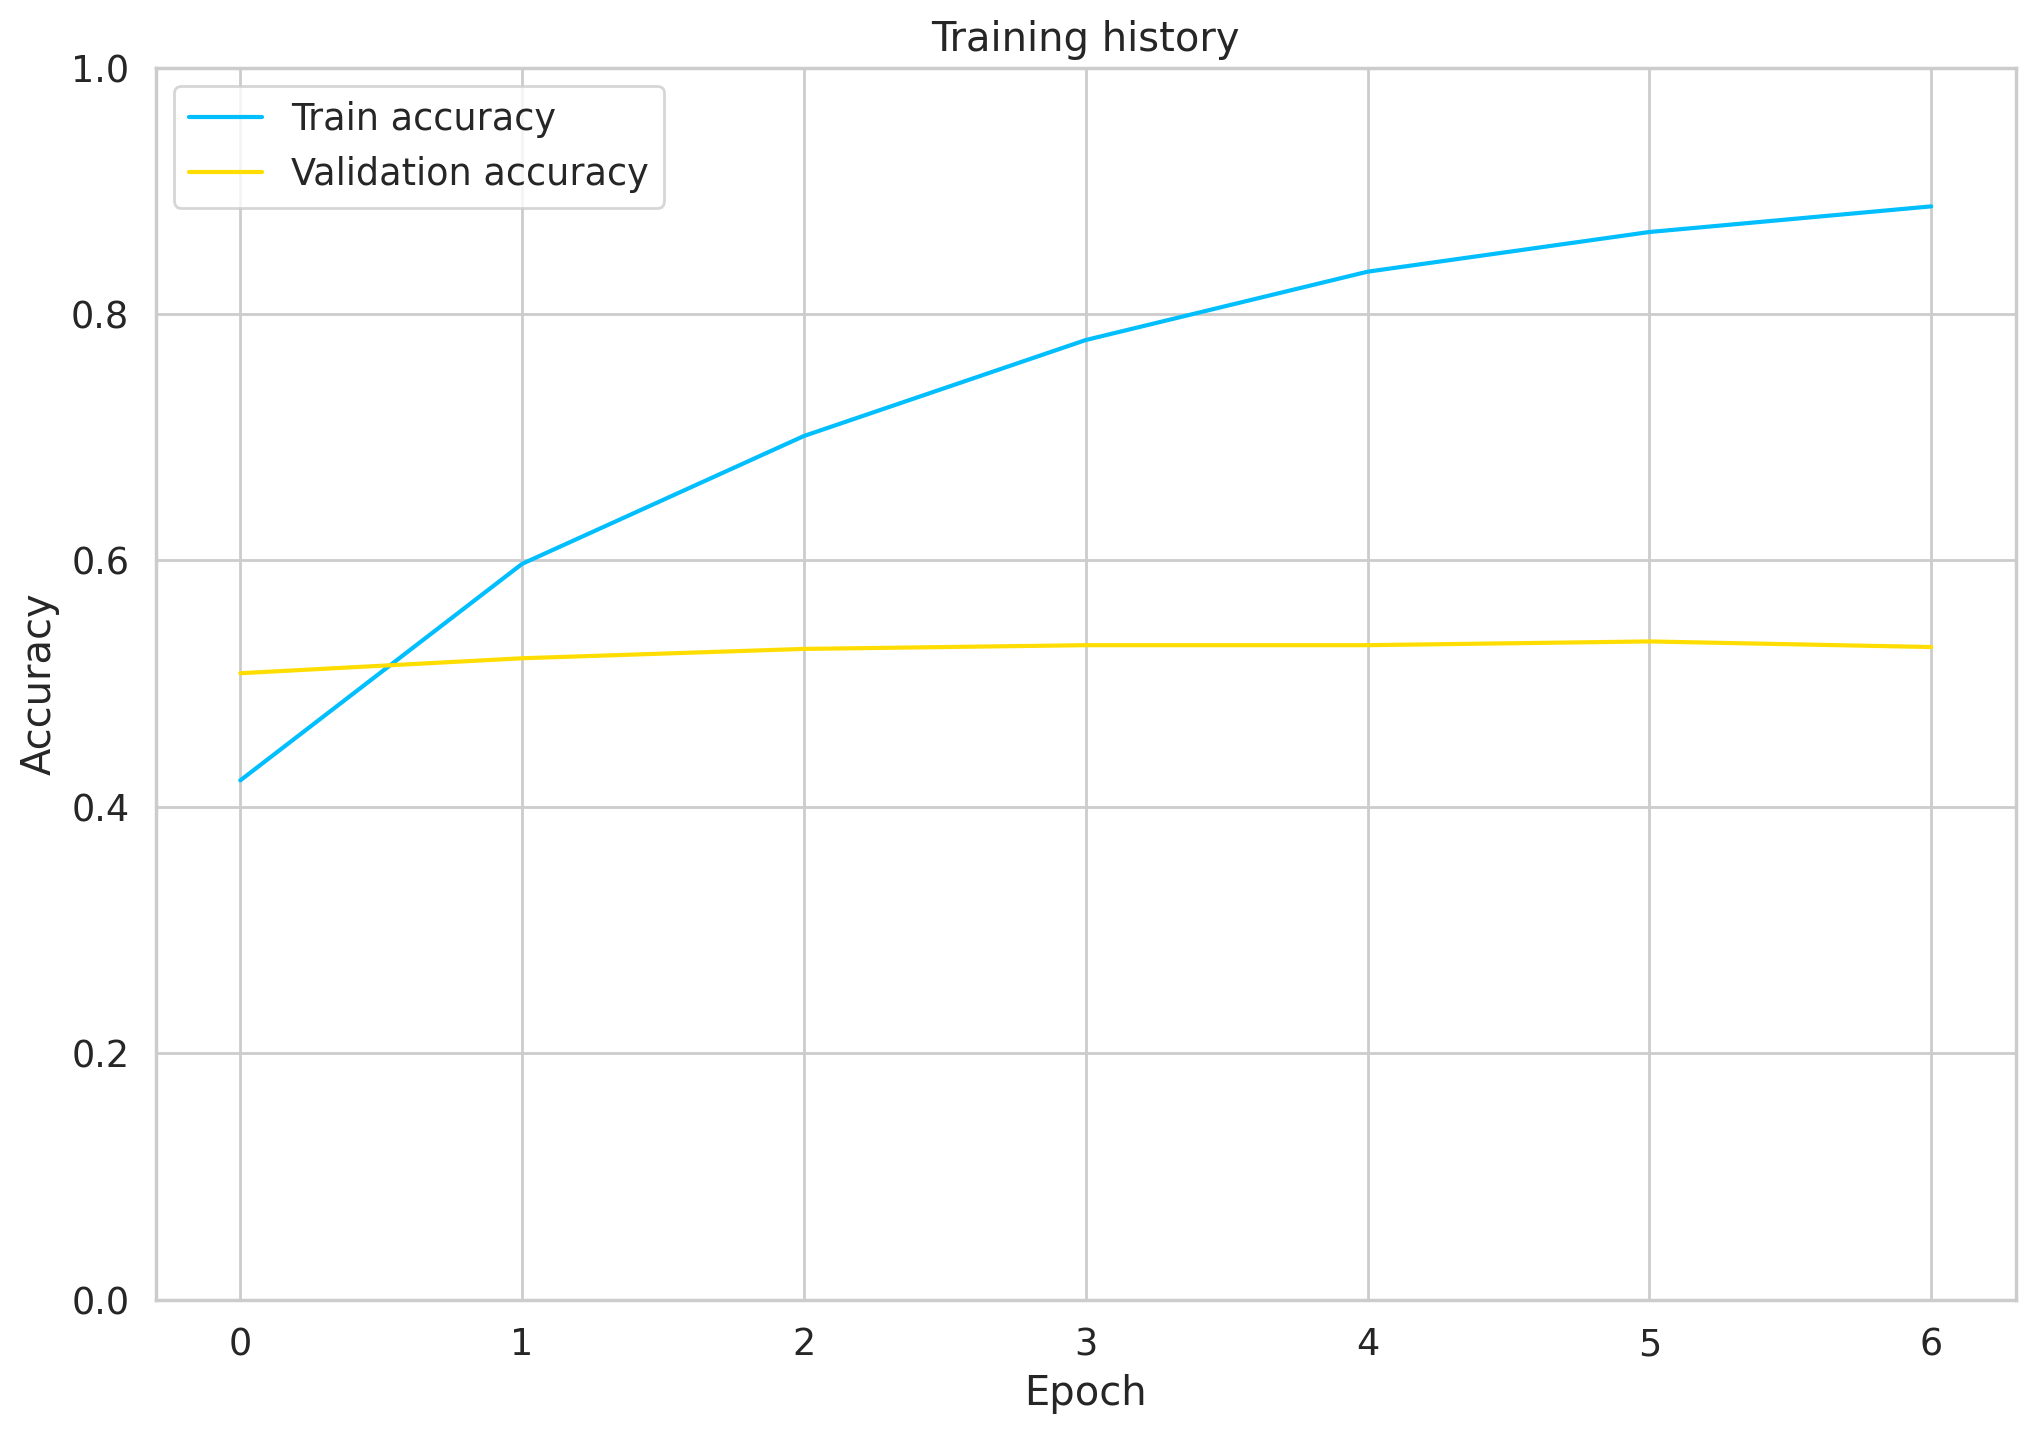

In [50]:
#Plot for train and val accuracy
plt.plot(new_training_acc, label='Train accuracy')
plt.plot(new_validation_acc, label='Validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

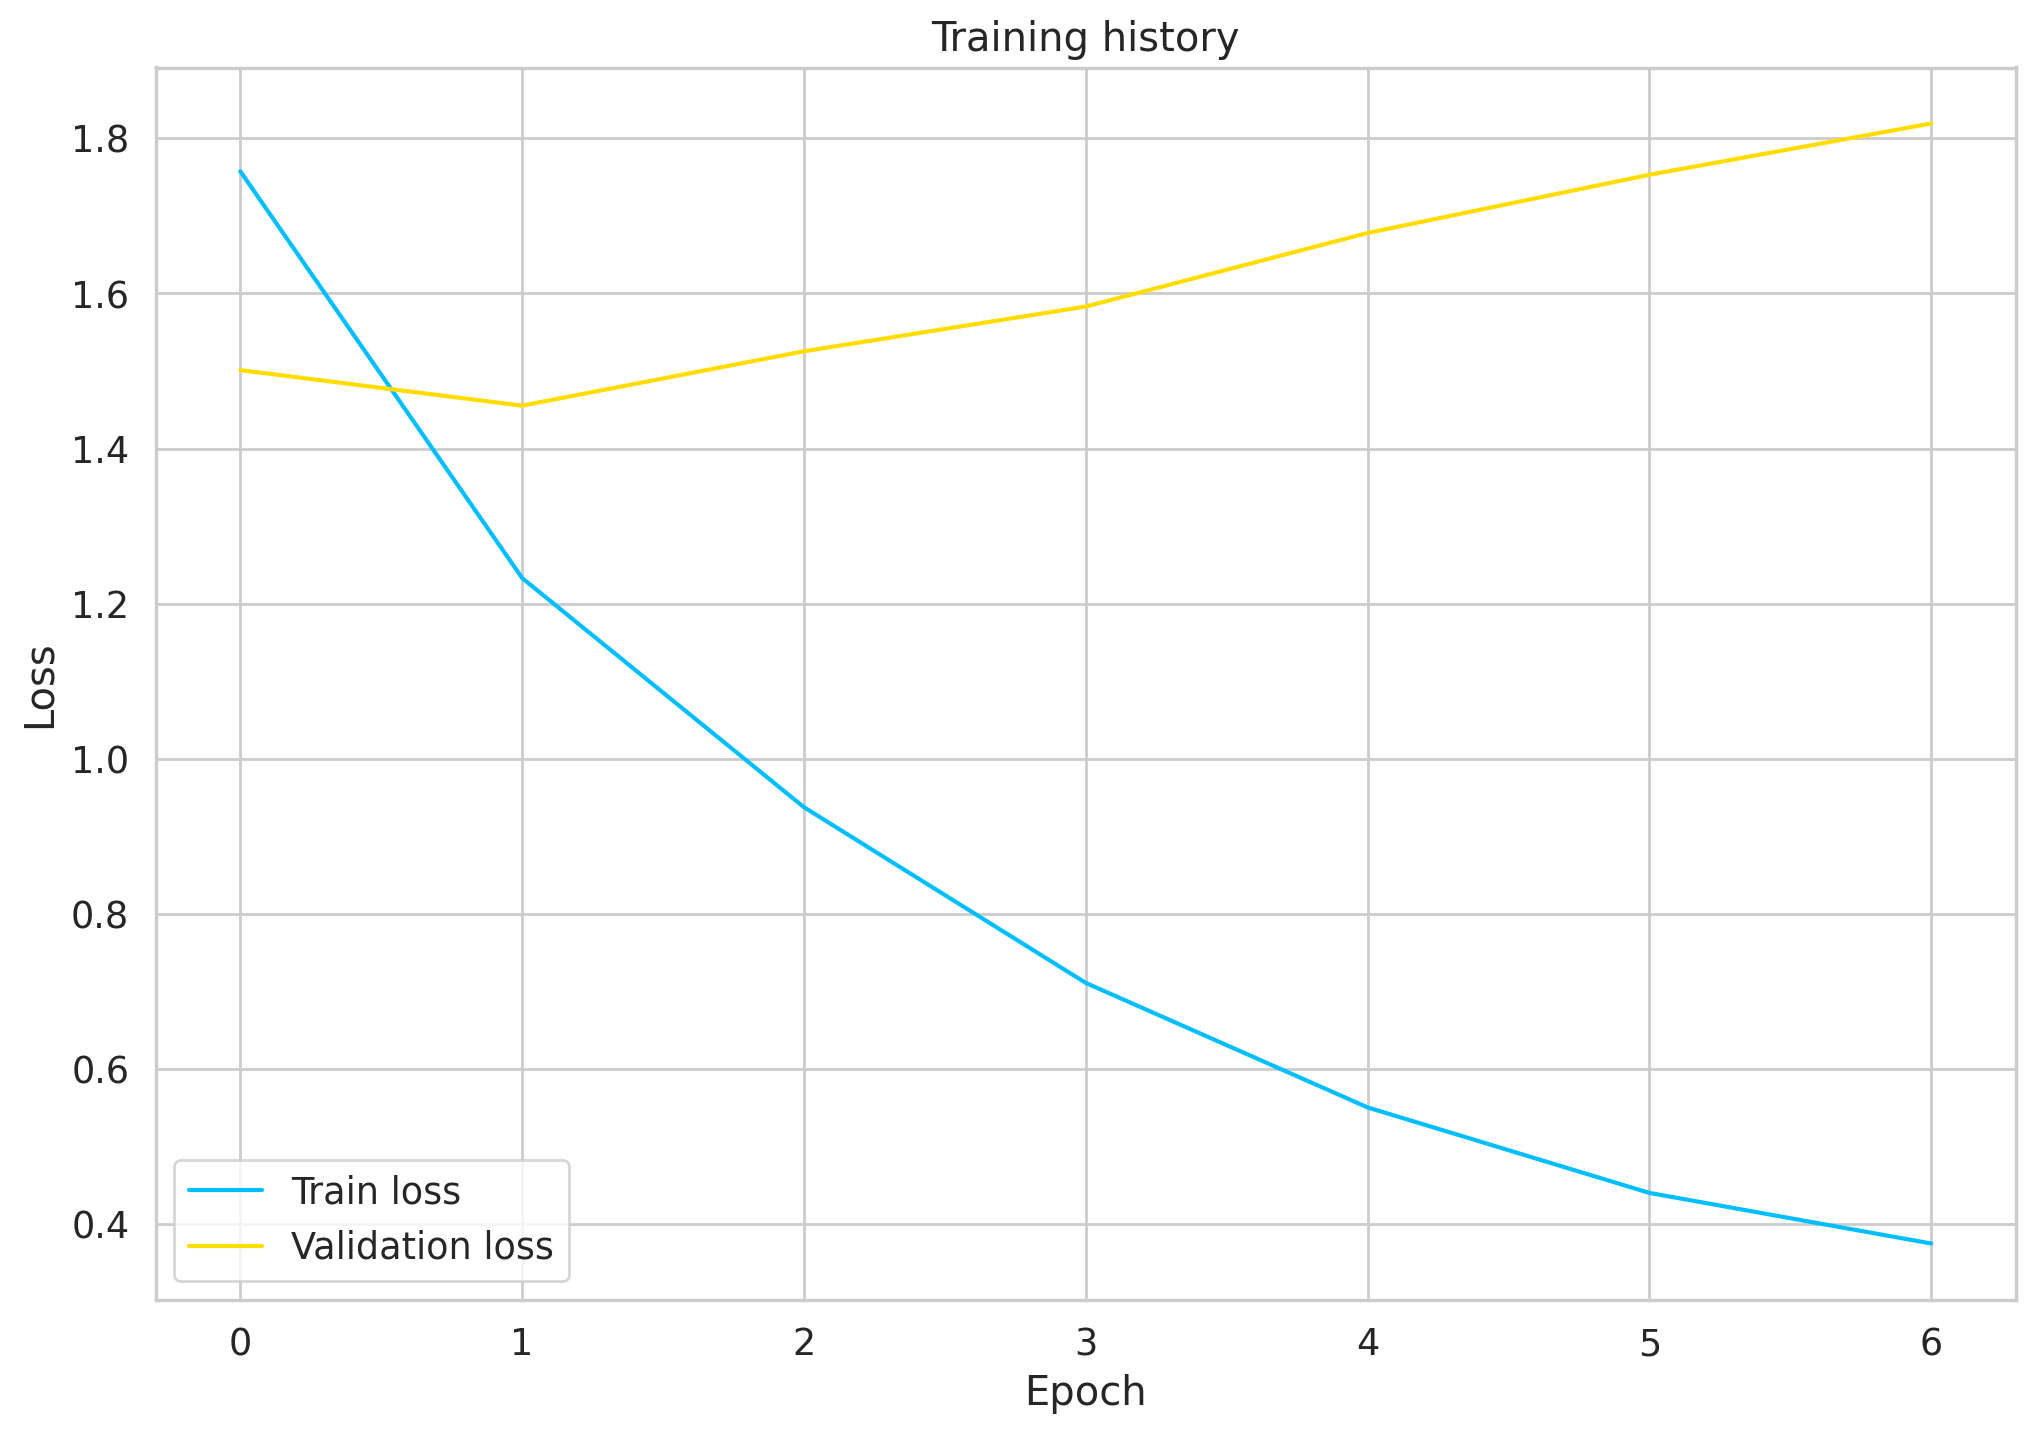

In [51]:
#Plot for train and val loss
plt.plot(training_loss, label='Train loss')
plt.plot(validation_loss, label='Validation loss')
plt.title('Training history')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend();

In [52]:
#Calculate accuracy on test data
test_acc, _ = evaluation(model_bert,test_data_loader,loss_fn,device,len(df_test))
test_acc.item()

100%|███████████████████████████████████████████| 42/42 [00:02<00:00, 14.03it/s]


0.5538694992412747

In [53]:
#Code for prediction on test data
def predictions(model, data_loader):
  model = model.eval()
  review_texts = [] #input sequence
  predictions = [] #predictions obtained
  prediction_probs = [] #list of pred probabilities
  real_values = [] #real labels
  with torch.no_grad():
    for element in data_loader:
      texts = element["Legal_text"] #input text sequence 
      input_ids = element["input_ids"].to(device) #getting encoded sequence
      attention_mask = element["attention_mask"].to(device) #gettting attention mask
      targets = element["targets"].to(device) #Actual labels
      outputs = model(input_ids=input_ids,attention_mask=attention_mask)
      _, preds = torch.max(outputs, dim=1)
      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(targets)
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [54]:
y_review_texts, y_pred, y_pred_probs, y_test = predictions(model_bert,test_data_loader)

In [55]:
#Code to get Classification Report
print(classification_report(y_test, y_pred, target_names=labels_set))

                precision    recall  f1-score   support

pre_not_relied       0.00      0.00      0.00         5
          none       0.84      0.76      0.80        78
      preamble       0.67      0.69      0.68        77
           fac       0.49      0.48      0.48        88
           rlc       0.37      0.42      0.39        31
           rpc       0.73      0.74      0.74        62
         issue       0.74      0.92      0.82        25
           sta       0.62      0.62      0.62        16
    pre_relied       0.49      0.53      0.51        66
arg_respondent       0.30      0.23      0.26        35
         ratio       0.38      0.48      0.42        31
arg_petitioner       0.57      0.59      0.58        61
      analysis       0.32      0.30      0.31        84

      accuracy                           0.55       659
     macro avg       0.50      0.52      0.51       659
  weighted avg       0.55      0.55      0.55       659



In [56]:
labels_index = list(labels_set)
labels_columns = list(labels_set)

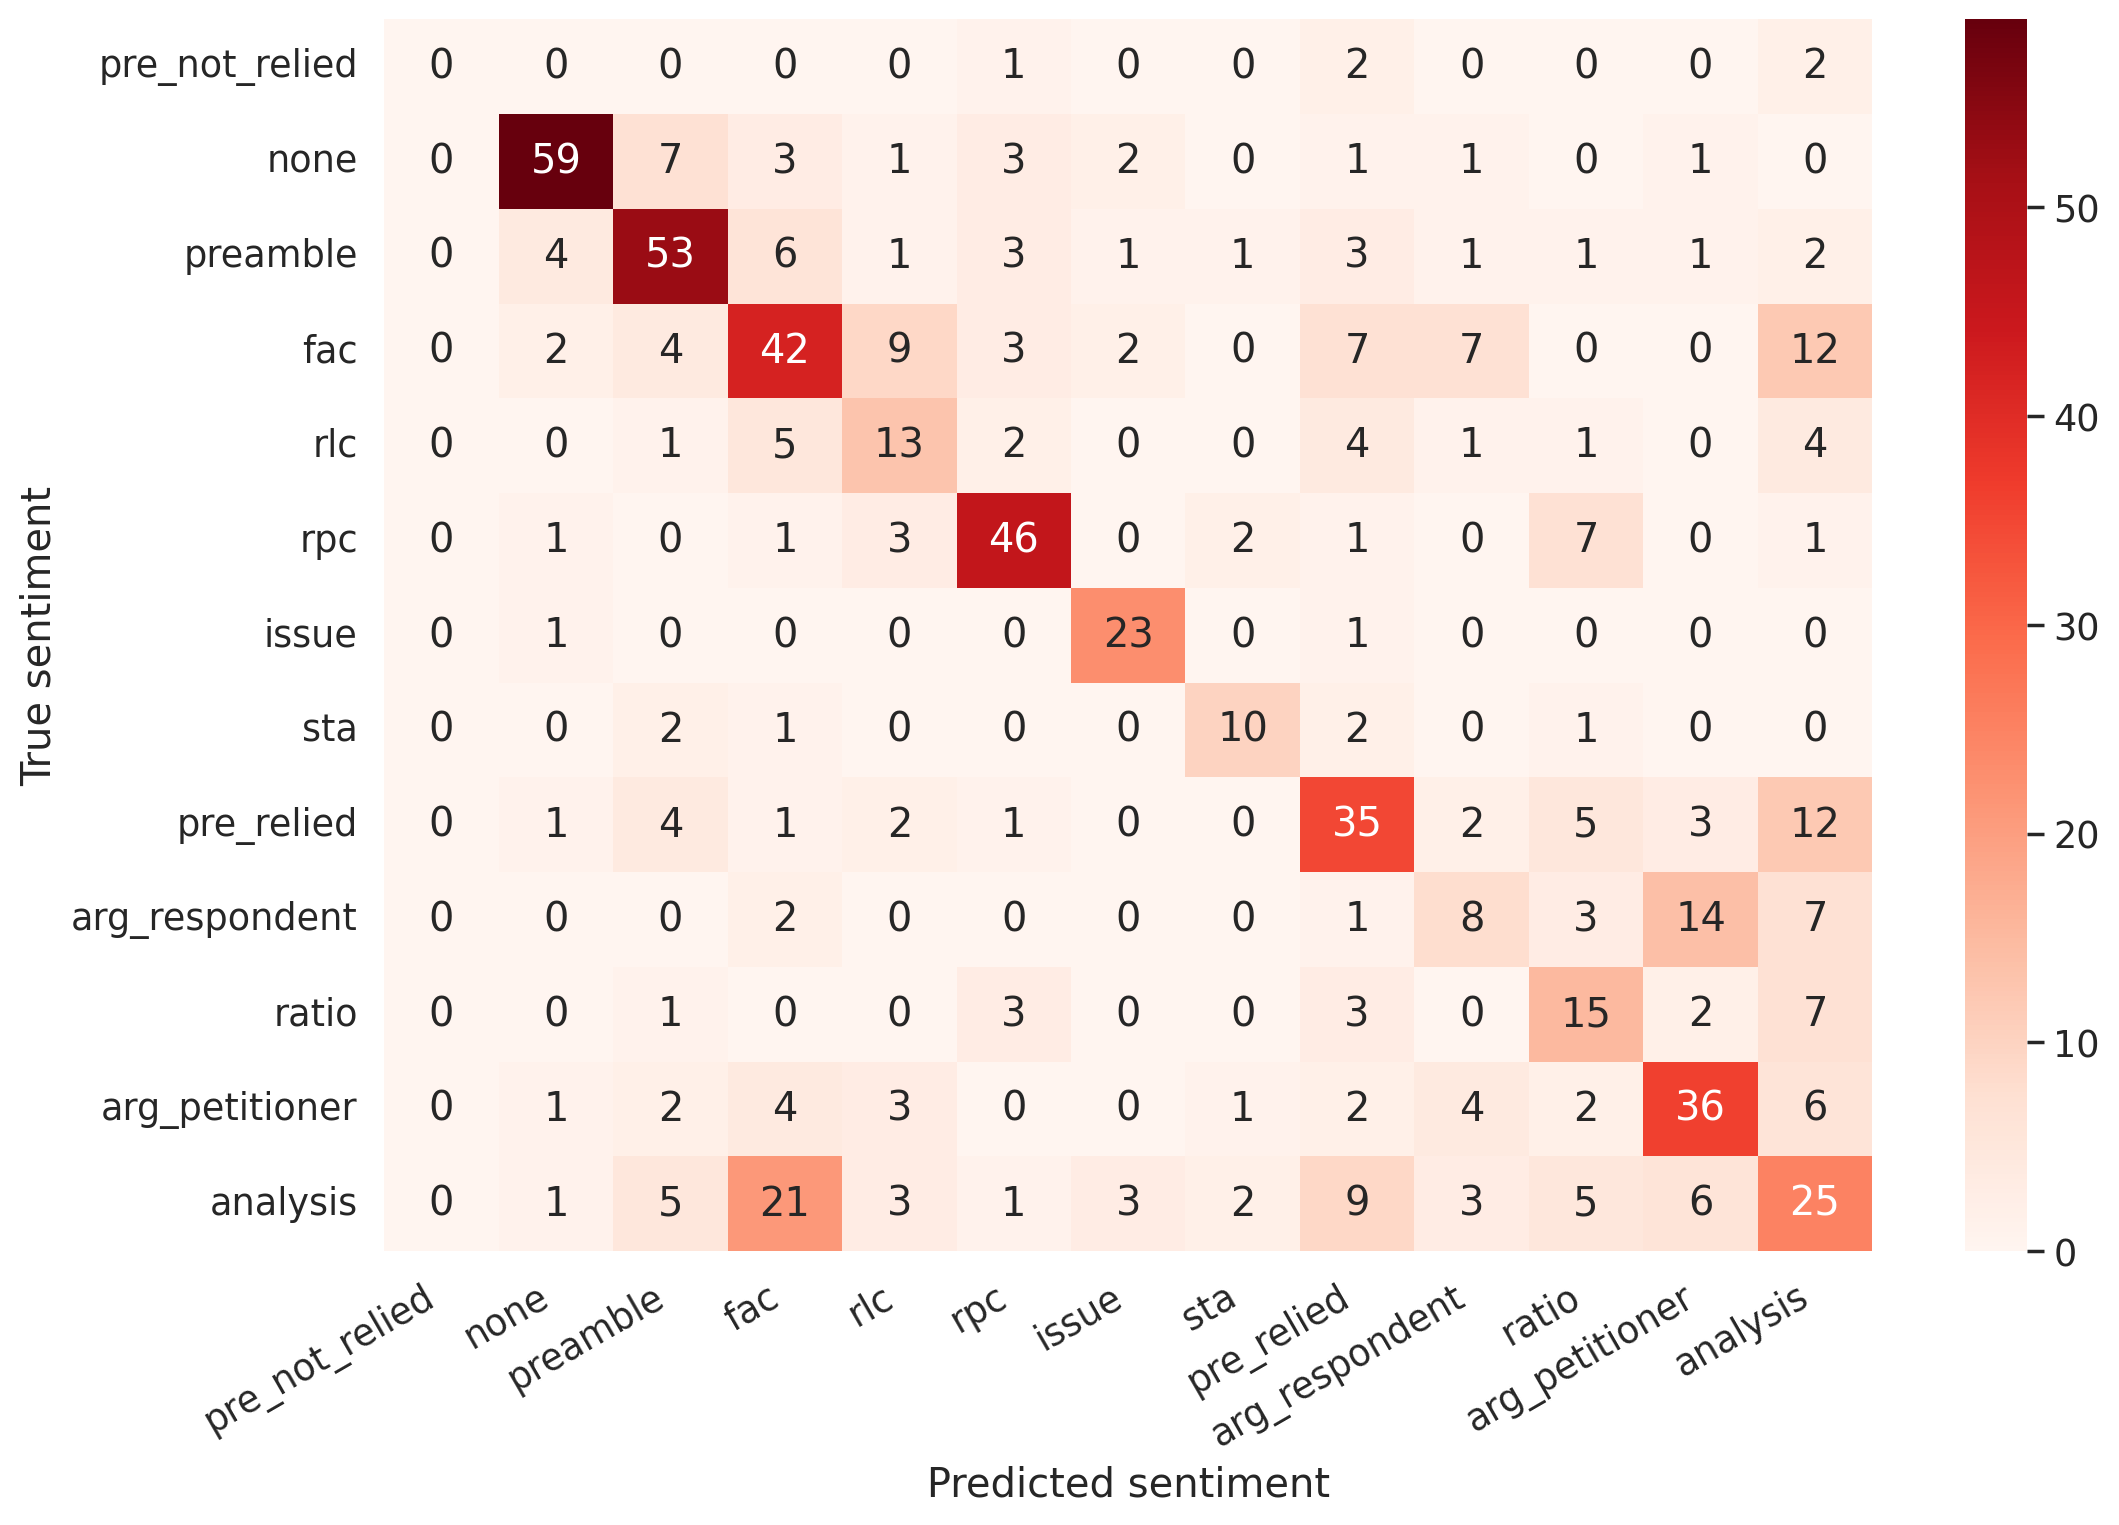

In [57]:
#Code to get the confusion matrix
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Reds")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=labels_index, columns=labels_columns)
show_confusion_matrix(df_cm)

# BERT + LSTM Model

In [58]:
#Code of BERT+LSTM class
class BERT_LSTM(nn.Module):
  def __init__(self,em_dim,output_tokens,padding_index=0):
        super(BERT_LSTM,self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased',return_dict=False)
        self.drop = nn.Dropout(0.3)
        self.fc1 = nn.Linear(self.bert.config.hidden_size, output_tokens)
        self.lstm=nn.LSTM(input_size=em_dim,hidden_size=self.bert.config.hidden_size,num_layers=1,batch_first=True,bidirectional=False)
        
  def forward(self,input_ids, attention_mask):
        _, pooled_output = self.bert(input_ids=input_ids,attention_mask=attention_mask)
        x=self.drop(pooled_output)
        out,hidden=self.lstm(x)
        h1=self.fc1(out)
        h2=h1.view(-1, h1.shape[-1])
        return h2

In [59]:
model = BERT_LSTM(768,len(labels_set)) # intializing the model
model = model.to(device) 

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [60]:
# hyperparameters 
EPOCHS = 15
total_steps = len(train_data_loader) * EPOCHS
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
loss_fn = nn.CrossEntropyLoss().to(device)
scheduler = get_linear_schedule_with_warmup(optimizer,num_warmup_steps=0,num_training_steps=total_steps)

In [61]:
#Code to train and evaluate the model
from collections import defaultdict
history = defaultdict(list)

training_acc = [] #list to store training accuracies
training_loss =[] # list to store training loss
validation_acc = [] # list to store validation accuracys
validation_loss =[] # list to store validation losses

best_accuracy = 0
for epoch in range(EPOCHS):
  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)
  train_acc, train_loss = training(model,train_data_loader,loss_fn,optimizer,device,scheduler,len(df_train))
  print(f'Train loss {train_loss} accuracy {train_acc}')
  val_acc, val_loss = evaluation(model,val_data_loader,loss_fn,device,len(df_val))
  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()
  history['train_acc'].append(train_acc)
  training_acc.append(train_acc)
  history['train_loss'].append(train_loss)
  training_loss.append(train_loss)
  history['val_acc'].append(val_acc)
  validation_acc.append(val_acc)
  history['val_loss'].append(val_loss)
  validation_loss.append(val_loss)
  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/15
----------


100%|█████████████████████████████████████████| 742/742 [02:46<00:00,  4.47it/s]


Train loss 2.1311375302767175 accuracy 0.27094924970494016


100%|███████████████████████████████████████████| 42/42 [00:03<00:00, 13.51it/s]


Val   loss 1.8729080557823181 accuracy 0.3884673748103187

Epoch 2/15
----------


100%|█████████████████████████████████████████| 742/742 [02:45<00:00,  4.47it/s]


Train loss 1.6852070684381573 accuracy 0.46231664137582196


100%|███████████████████████████████████████████| 42/42 [00:03<00:00, 13.62it/s]


Val   loss 1.7459415310905093 accuracy 0.4339908952959029

Epoch 3/15
----------


100%|█████████████████████████████████████████| 742/742 [02:48<00:00,  4.40it/s]


Train loss 1.407703935296709 accuracy 0.562131175181251


100%|███████████████████████████████████████████| 42/42 [00:03<00:00, 13.68it/s]


Val   loss 1.6264008865469979 accuracy 0.4749620637329287

Epoch 4/15
----------


100%|█████████████████████████████████████████| 742/742 [02:46<00:00,  4.47it/s]


Train loss 1.1891099783689827 accuracy 0.633451357275333


100%|███████████████████████████████████████████| 42/42 [00:03<00:00, 13.66it/s]


Val   loss 1.590070711714881 accuracy 0.5022761760242792

Epoch 5/15
----------


100%|█████████████████████████████████████████| 742/742 [02:45<00:00,  4.48it/s]


Train loss 1.018990871318267 accuracy 0.6890069128308886


100%|███████████████████████████████████████████| 42/42 [00:03<00:00, 13.54it/s]


Val   loss 1.6489981725102378 accuracy 0.5098634294385432

Epoch 6/15
----------


100%|█████████████████████████████████████████| 742/742 [02:47<00:00,  4.43it/s]


Train loss 0.8976786534058437 accuracy 0.7287135390322037


100%|███████████████████████████████████████████| 42/42 [00:03<00:00, 13.21it/s]


Val   loss 1.6932791031542278 accuracy 0.5189681335356601

Epoch 7/15
----------


100%|█████████████████████████████████████████| 742/742 [02:48<00:00,  4.41it/s]


Train loss 0.775216742928298 accuracy 0.7670713201820941


100%|███████████████████████████████████████████| 42/42 [00:03<00:00, 13.54it/s]


Val   loss 1.7491739023299444 accuracy 0.5204855842185129

Epoch 8/15
----------


100%|█████████████████████████████████████████| 742/742 [02:47<00:00,  4.43it/s]


Train loss 0.6851624784805382 accuracy 0.7964087000505816


100%|███████████████████████████████████████████| 42/42 [00:03<00:00, 13.10it/s]


Val   loss 1.788134793440501 accuracy 0.5326251896813353

Epoch 9/15
----------


100%|█████████████████████████████████████████| 742/742 [02:48<00:00,  4.40it/s]


Train loss 0.5959877426412228 accuracy 0.8275164390490642


100%|███████████████████████████████████████████| 42/42 [00:03<00:00, 12.93it/s]


Val   loss 1.862795746042615 accuracy 0.5250379362670713

Epoch 10/15
----------


100%|█████████████████████████████████████████| 742/742 [02:46<00:00,  4.47it/s]


Train loss 0.5310415756710456 accuracy 0.8494351711347159


100%|███████████████████████████████████████████| 42/42 [00:03<00:00, 12.94it/s]


Val   loss 1.901059085414523 accuracy 0.5295902883156297

Epoch 11/15
----------


100%|█████████████████████████████████████████| 742/742 [02:47<00:00,  4.43it/s]


Train loss 0.4573729186948901 accuracy 0.876074860900354


100%|███████████████████████████████████████████| 42/42 [00:03<00:00, 12.87it/s]


Val   loss 1.96897193079903 accuracy 0.5341426403641882

Epoch 12/15
----------


100%|█████████████████████████████████████████| 742/742 [02:48<00:00,  4.40it/s]


Train loss 0.41823535296071895 accuracy 0.8882987691788905


100%|███████████████████████████████████████████| 42/42 [00:03<00:00, 13.26it/s]


Val   loss 2.030579436393011 accuracy 0.5295902883156297

Epoch 13/15
----------


100%|█████████████████████████████████████████| 742/742 [02:47<00:00,  4.42it/s]


Train loss 0.38332933994798324 accuracy 0.8998482549317147


100%|███████████████████████████████████████████| 42/42 [00:03<00:00, 13.08it/s]


Val   loss 2.0984153917857578 accuracy 0.5220030349013657

Epoch 14/15
----------


100%|█████████████████████████████████████████| 742/742 [02:48<00:00,  4.40it/s]


Train loss 0.34997235862111464 accuracy 0.9101331984488281


100%|███████████████████████████████████████████| 42/42 [00:03<00:00, 13.21it/s]


Val   loss 2.120474894841512 accuracy 0.5220030349013657

Epoch 15/15
----------


100%|█████████████████████████████████████████| 742/742 [02:43<00:00,  4.53it/s]


Train loss 0.33132236211929683 accuracy 0.9160343955488113


100%|███████████████████████████████████████████| 42/42 [00:03<00:00, 13.09it/s]

Val   loss 2.1312275585674105 accuracy 0.5250379362670713



In [62]:
new_training_acc =[]
for i in training_acc:
  x= i.to("cpu") 
  final = x.numpy()
  new_training_acc.append(final)

new_validation_acc =[]
for i in validation_acc:
  x= i.to("cpu") 
  final = x.numpy()
  new_validation_acc.append(final)

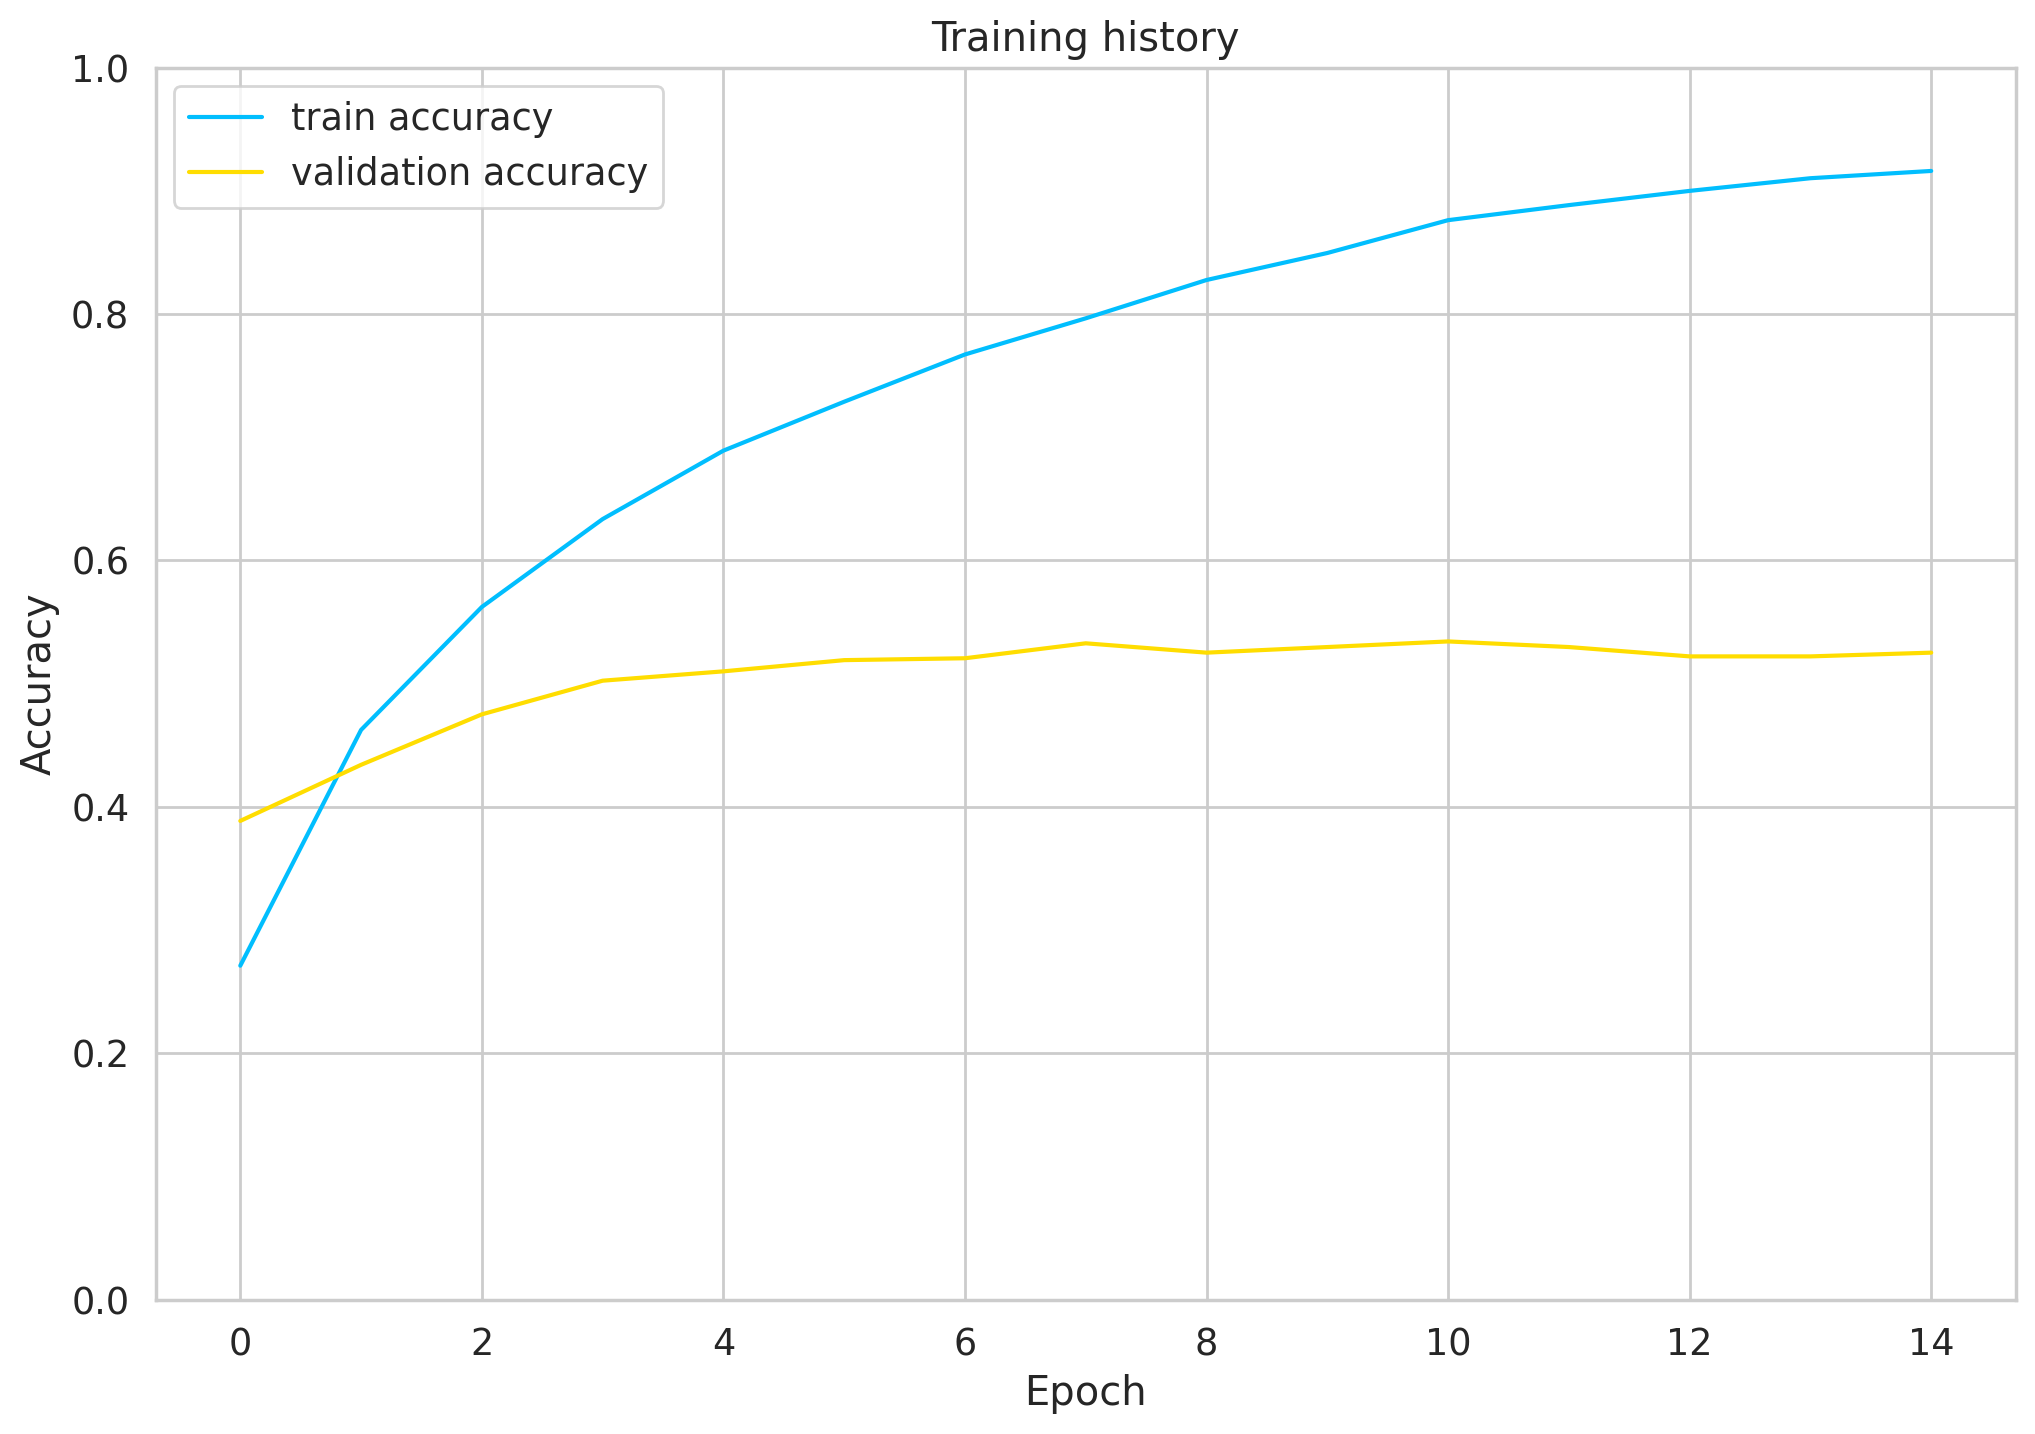

In [63]:
#Plot for train and val accuracy
plt.plot(new_training_acc, label='train accuracy')
plt.plot(new_validation_acc, label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

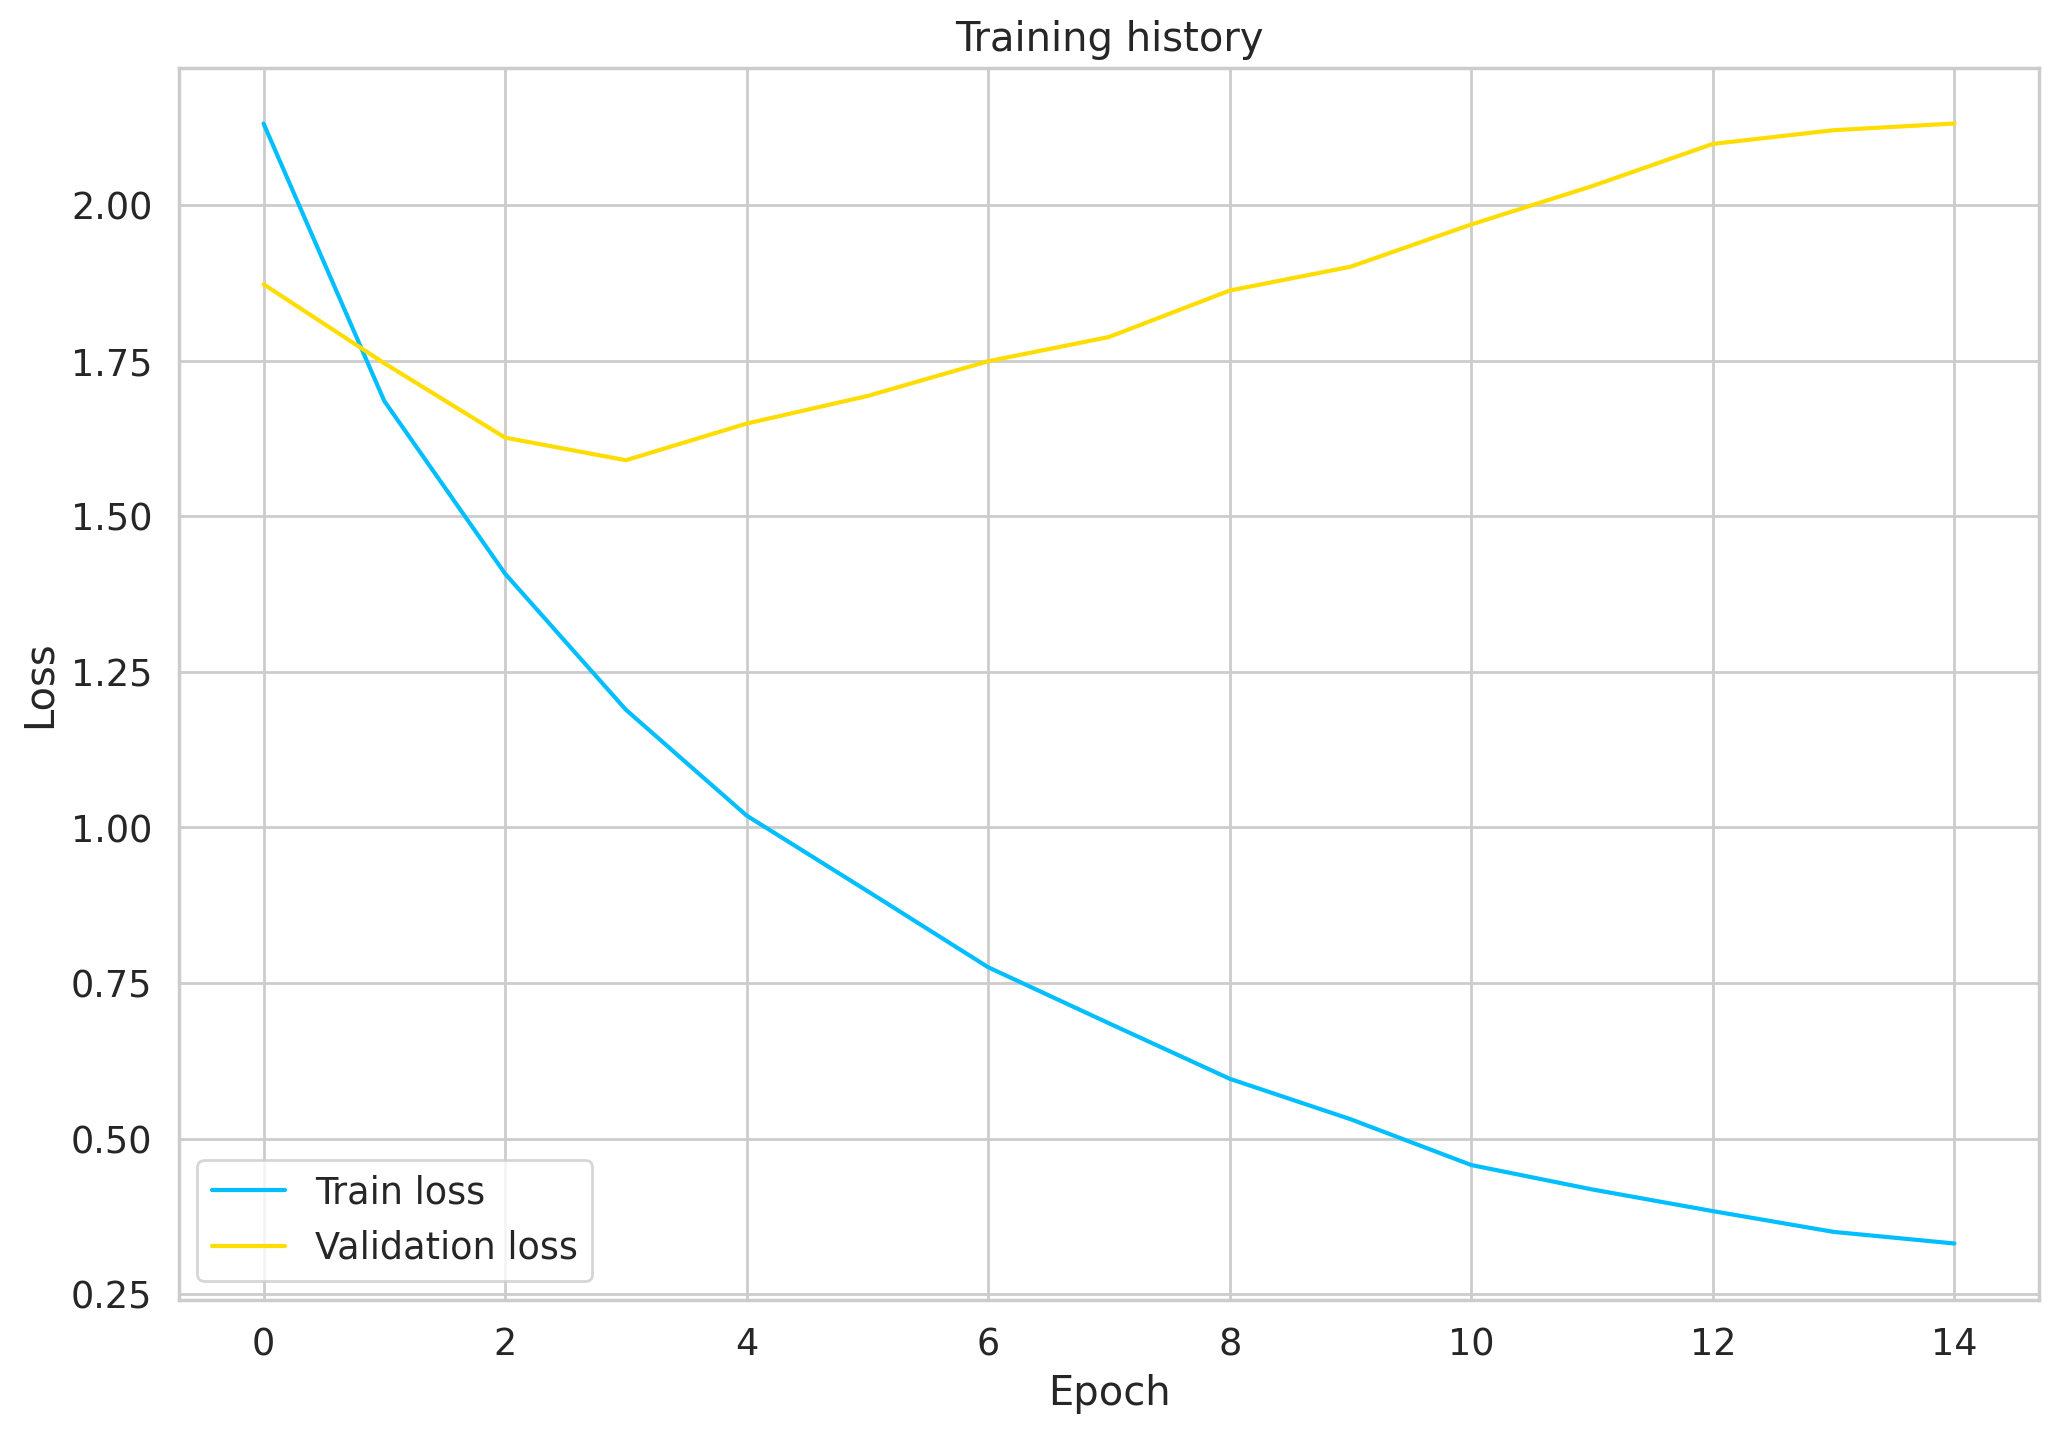

In [64]:
#Plot for train and val loss
plt.plot(training_loss, label='Train loss')
plt.plot(validation_loss, label='Validation loss')
plt.title('Training history')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend();

In [65]:
test_acc, _ = evaluation(model,test_data_loader,loss_fn,device,len(df_test))
test_acc.item()

100%|███████████████████████████████████████████| 42/42 [00:03<00:00, 13.42it/s]


0.5629742033383915

In [66]:
y_review_texts, y_pred, y_pred_probs, y_test = predictions(model,test_data_loader)

In [67]:
#Code to get Classification Report
print(classification_report(y_test, y_pred, target_names=labels_set))

                precision    recall  f1-score   support

pre_not_relied       0.00      0.00      0.00         5
          none       0.80      0.77      0.78        78
      preamble       0.70      0.68      0.69        77
           fac       0.57      0.49      0.52        88
           rlc       0.37      0.42      0.39        31
           rpc       0.80      0.73      0.76        62
         issue       0.77      0.80      0.78        25
           sta       0.50      0.56      0.53        16
    pre_relied       0.56      0.56      0.56        66
arg_respondent       0.27      0.29      0.28        35
         ratio       0.36      0.39      0.38        31
arg_petitioner       0.55      0.56      0.55        61
      analysis       0.36      0.43      0.39        84

      accuracy                           0.56       659
     macro avg       0.51      0.51      0.51       659
  weighted avg       0.57      0.56      0.57       659



In [68]:
labels_index = list(labels_set)
labels_columns = list(labels_set)

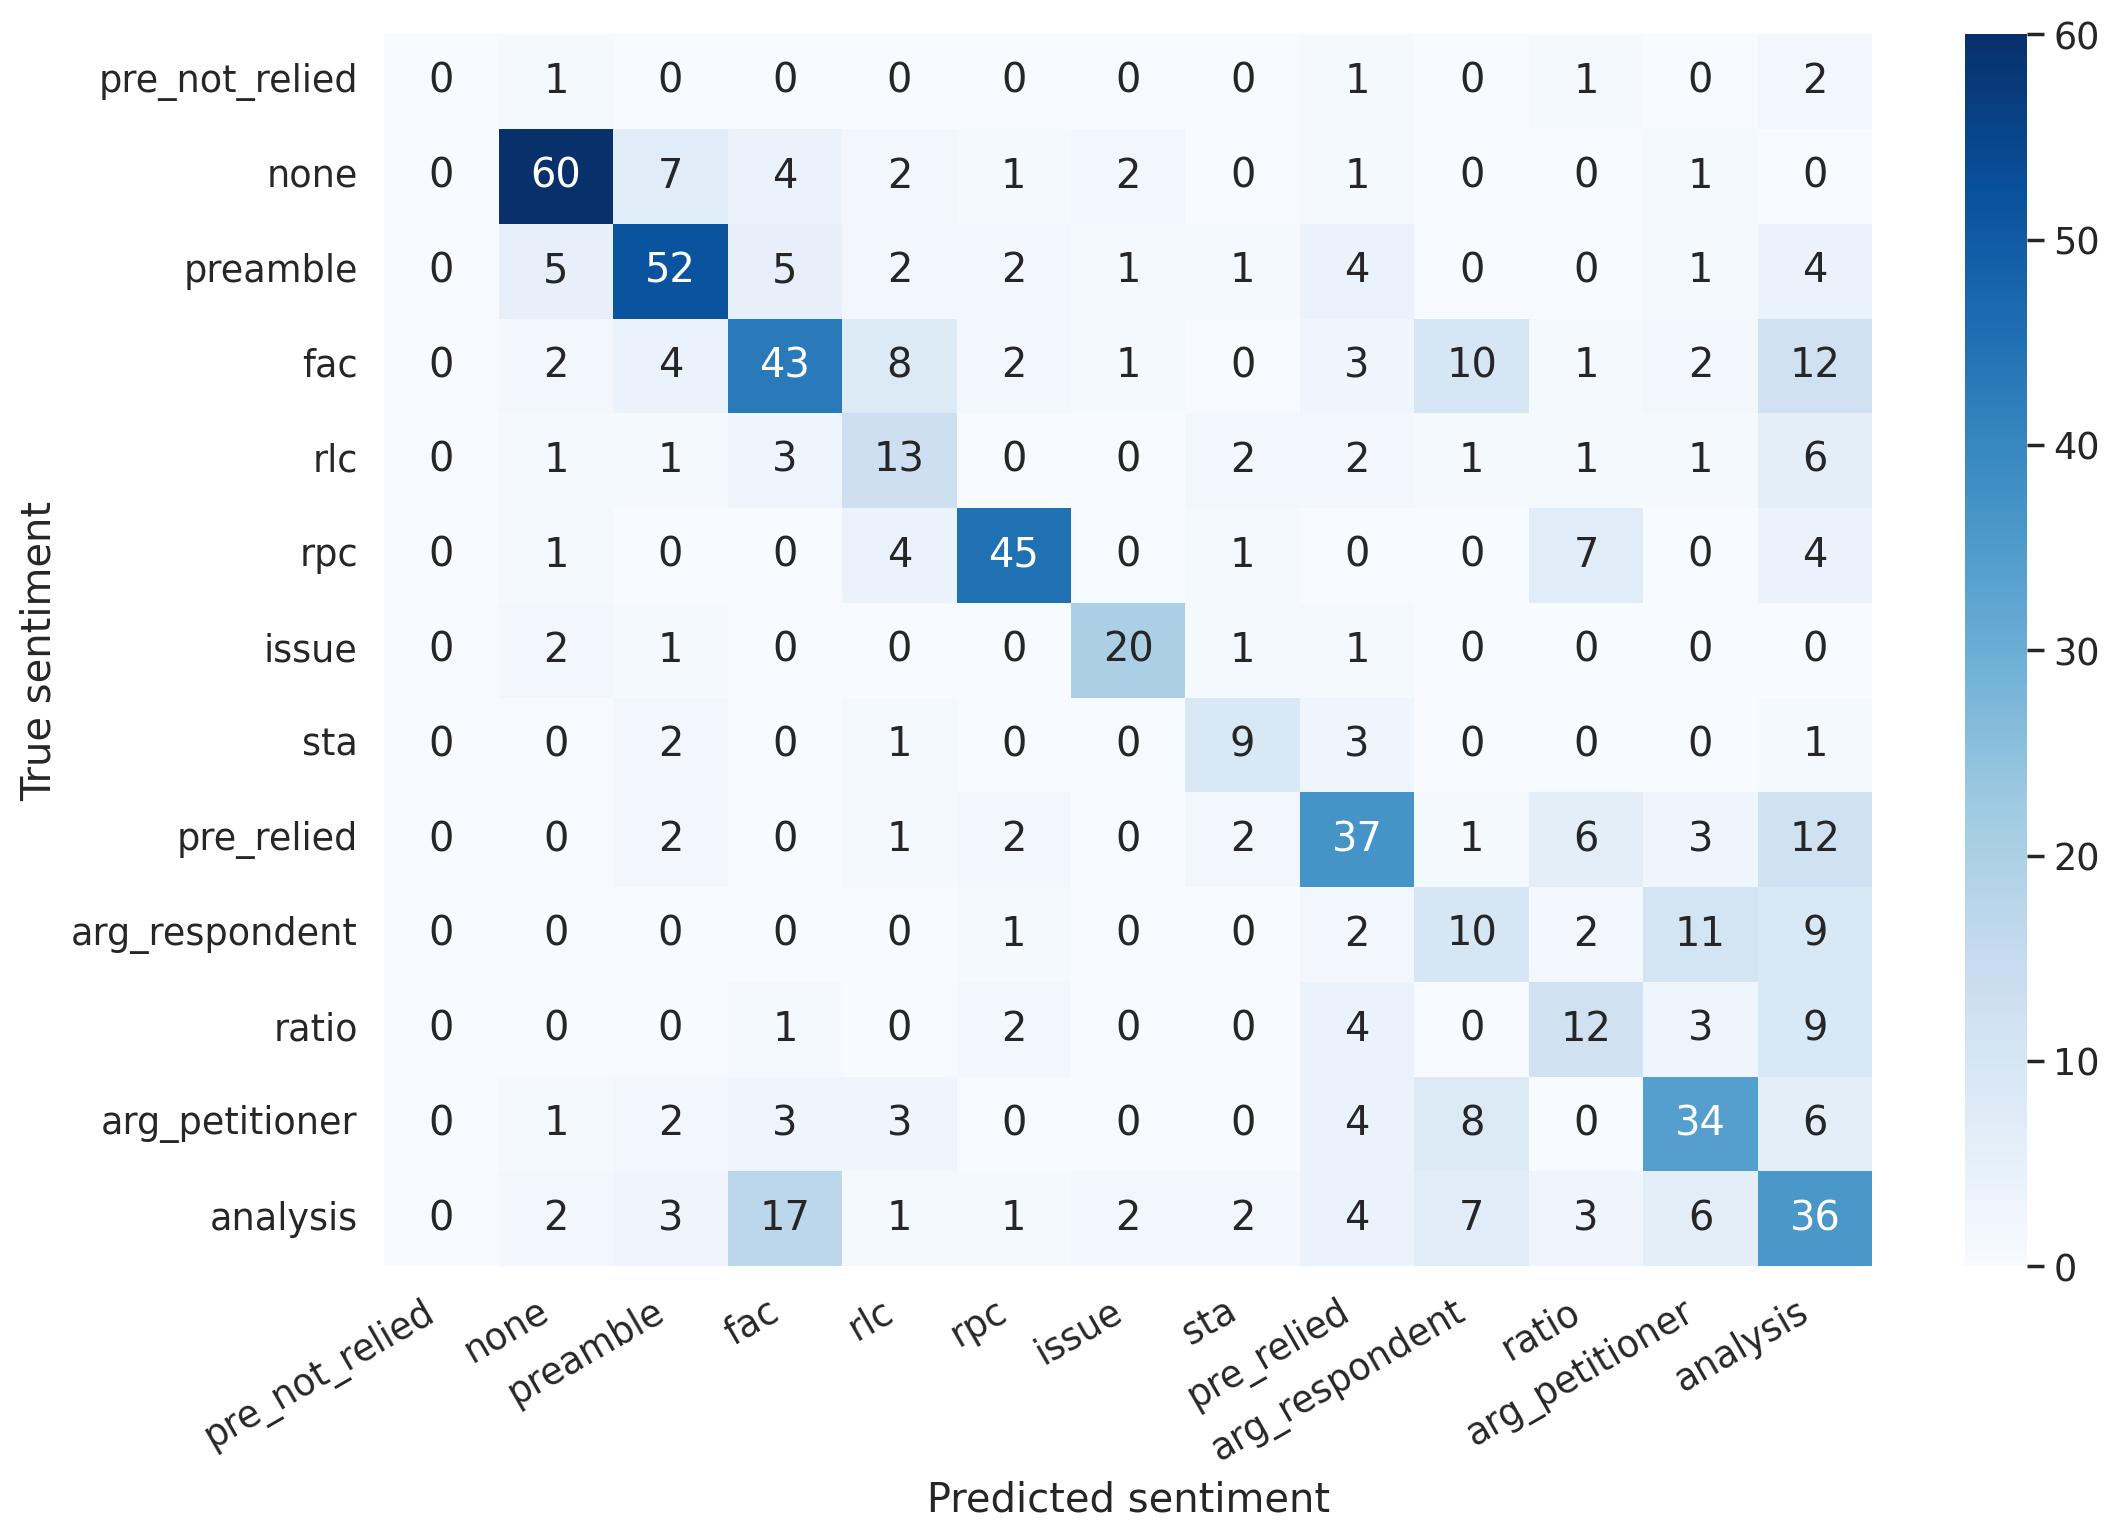

In [69]:
#Code to get confusion matrix
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=labels_index, columns=labels_columns)
show_confusion_matrix(df_cm)